In [10]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2")

In [11]:
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage

class State(MessagesState):
  received_message: AnyMessage
  generated_message: AnyMessage
  human_approval: str
  pass


In [12]:
# node
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
def human_feedback(state):
  pass

def reply_text_llm(state):
  sys_msg = f"""
  You are a text messaging replying assistant. 
  The user (Stephen) is having text messages with his girl (Deidra), and he needs to send replies back to her messages. You are going to generate possible reply messages to the following text messages. 
  
  You are going to generate One potential reply messages on behalf of the user. Don't add any explanation. Just output the text message.
  """
  if not state.get('human_approval'):
    command = f"""You generated this text last time: {state['generated_message'].content} and the user didn't like the message. Generate another reply message with different sentiment."""
  else:
    command = """
    Help me generate reply message
    """  
  
  return {
    'generated_message': llm.invoke([
      SystemMessage(sys_msg),
      HumanMessage(command)
    ])
  }

def update_messages(state):
  return {
    'messages': HumanMessage(content=state['generated_message'].content, name="Stephen")
  }
# edge

def human_approval_conditional(state):
  if state.get('human_approval'):
    return "update_messages"
    
  else:
    return 'reply_text_llm'
  

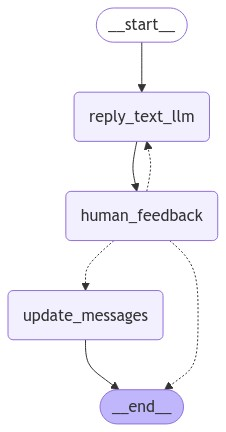

In [13]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(State)
builder.add_node(reply_text_llm)
builder.add_node(human_feedback)
builder.add_node(update_messages)


builder.add_edge(START, "reply_text_llm")
builder.add_edge('reply_text_llm', 'human_feedback')
builder.add_conditional_edges('human_feedback', human_approval_conditional)
builder.add_edge('update_messages', END)

memory = MemorySaver()
graph = builder.compile(memory)

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
ds_message = "Hi, Stephen. How are you doing this morning?"
state = {
  'messages': HumanMessage(content=ds_message, name="Deidra"),
}
config = {"configurable": {"thread_id": 1}}
for state in graph.stream(state, stream_mode="values", interrupt_before='human-feedback', config=config):
  print(state['messages'][-1])
  if generated_message := messages.get('generated_message'):
    print("===" * 25)
    print(generated_message)
    print("===" * 25)
  print('---' * 25)


content='Hi, Stephen. How are you doing this morning?' additional_kwargs={} response_metadata={} name='Deidra' id='1357acae-3568-4987-a89b-ddd42d05b8d4'
---------------------------------------------------------------------------


AttributeError: 'list' object has no attribute 'content'

In [7]:
approvals = ['yes', 'y', 'sure']
human_feedback = input('Do you approve?: ')

if human_feedback in approvals:
  graph.update_state(config, values={'human_approval': True})  
else:
  graph.update_state(config, values={'human_approval': False})  


{'configurable': {'thread_id': 1,
  'checkpoint_ns': '',
  'checkpoint_id': '1ef91677-6224-6419-8004-cdb4b9486a38'}}

In [9]:
graph.get_state(config)


StateSnapshot(values={'messages': [AIMessage(content="I'm good, thanks for asking. How about you?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-23T17:51:23.1938583Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 348798800, 'load_duration': 28763600, 'prompt_eval_count': 133, 'prompt_eval_duration': 29297000, 'eval_count': 13, 'eval_duration': 287205000}, id='run-49d81dd3-84a1-4b95-b046-382a9c0fbdb4-0', usage_metadata={'input_tokens': 133, 'output_tokens': 13, 'total_tokens': 146})], 'received_message': HumanMessage(content='Hi, Stephen. How are you doing this morning?', additional_kwargs={}, response_metadata={}), 'generated_message': AIMessage(content="I'm good, thanks for asking. How about you?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-23T17:51:23.1938583Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True

In [46]:
# Node

